<a href="https://colab.research.google.com/github/Avichay3/final_project_eyal/blob/main/final_project_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install transformers datasets evaluate -q
!pip install torch torchvision torchaudio -q
!pip install scikit-learn pandas numpy -q


import os
os.environ["WANDB_DISABLED"] = "true"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


In [2]:

from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]

Saving heldout_pair_data.jsonlist to heldout_pair_data.jsonlist


In [3]:

import json
data = [json.loads(line) for line in open(file_name, 'r')]
df = pd.DataFrame(data)
print("Columns:", df.columns.tolist())


pos_df = pd.DataFrame({
    "text": df["positive"],
    "label": 1
})
neg_df = pd.DataFrame({
    "text": df["negative"],
    "label": 0
})

combined_df = pd.concat([pos_df, neg_df], ignore_index=True)
combined_df = combined_df.dropna(subset=["text"]).reset_index(drop=True)


combined_df["text"] = combined_df["text"].apply(
    lambda x: " ".join(x) if isinstance(x, list) else str(x)
)

print("Total samples:", len(combined_df))
combined_df.head()

Columns: ['op_author', 'op_text', 'op_title', 'positive', 'negative', 'op_name']
Total samples: 1614


,text,label
0,"{'ancestor': 't1_cundk5r', 'author': 'ghoooooo...",1
1,"{'ancestor': 't1_cunbkbz', 'author': 'archagon...",1
2,"{'ancestor': 't1_cun0c3t', 'author': 'huadpe',...",1
3,"{'ancestor': 't1_cumn3j4', 'author': 'ReOsIr10...",1
4,"{'ancestor': 't1_cumhf65', 'author': 'BadKeyMa...",1


In [6]:
pairs = []

for sample in data:
    op_text = sample.get("op_text", "")

    # positive comment(s)
    if isinstance(sample.get("positive"), dict):
        comments = sample["positive"].get("comments", [])
        for c in comments:
            comment_text = c.get("body", "")
            if comment_text:
                pairs.append({
                    "op_text": op_text,
                    "cm_text": comment_text,
                    "label": 1
                })

    # negative comment(s)
    if isinstance(sample.get("negative"), dict):
        comments = sample["negative"].get("comments", [])
        for c in comments:
            comment_text = c.get("body", "")
            if comment_text:
                pairs.append({
                    "op_text": op_text,
                    "cm_text": comment_text,
                    "label": 0
                })

combined_df = pd.DataFrame(pairs)
combined_df = combined_df.dropna(subset=["op_text", "cm_text"]).reset_index(drop=True)
print("Total pairs:", len(combined_df))
print(combined_df.sample(3))


Total pairs: 2142
                                                op_text  \
659   I'm not talking about merely "popular". But a ...   
125   Country music was not always bad. There were l...   
2024  **Edit: Ok guy's, my views have been changed o...   

                                                cm_text  label  
659   The White Stripes/Jack White had almost single...      1  
125   It's doubtful words are going to convince you ...      1  
2024  So, I just put the finishing touches on a pape...      1  


In [7]:
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    random_state=42,
    stratify=combined_df["label"]
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Some EDA

total samples: 1614
train samples: 1291
test samples: 323

Label distribution (0 = Not Persuasive, 1 = Persuasive):
label
1    807
0    807
Name: count, dtype: int64


/tmp/ipython-input-86125451.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=combined_df, x='label', palette='pastel')


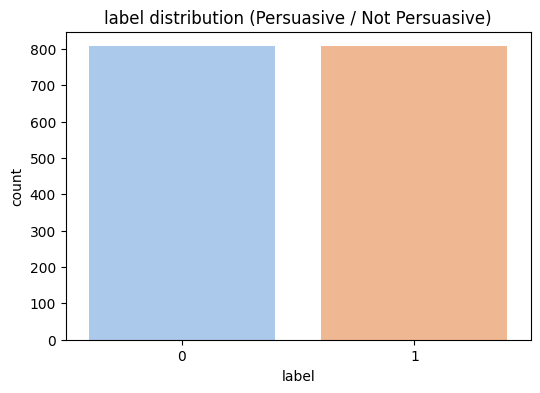

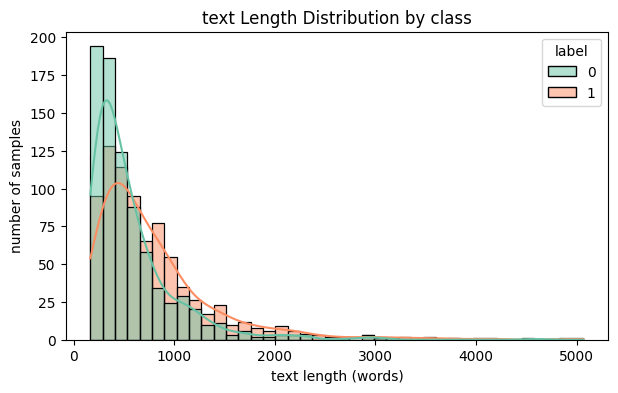

/tmp/ipython-input-86125451.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_pos, x='count', y='word', palette='Greens_r')
/tmp/ipython-input-86125451.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_neg, x='count', y='word', palette='Reds_r')


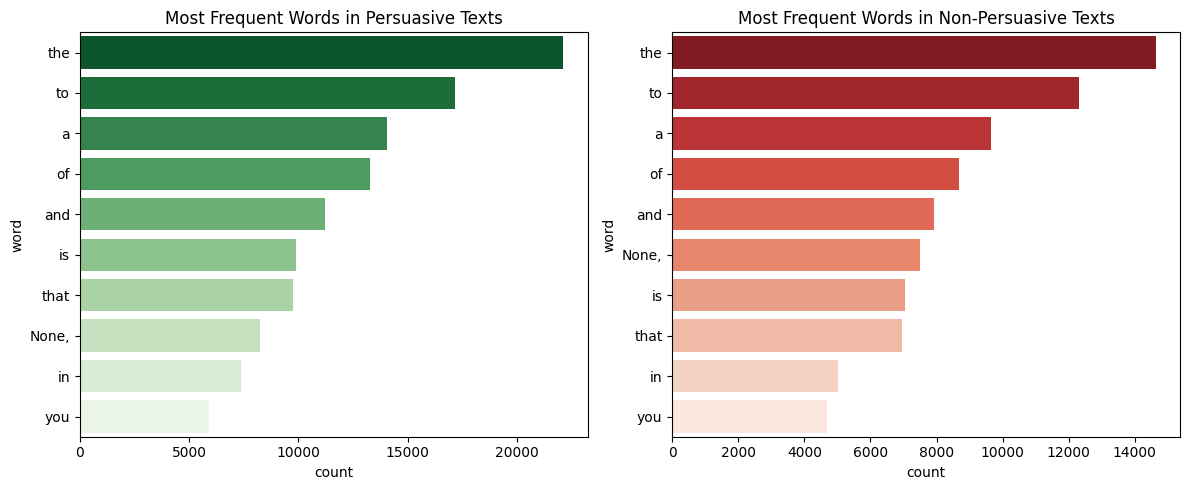

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

print("total samples:", len(combined_df))
print("train samples:", len(train_df))
print("test samples:", len(test_df))
print("\nLabel distribution (0 = Not Persuasive, 1 = Persuasive):")
print(combined_df['label'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(data=combined_df, x='label', palette='pastel')
plt.title("label distribution (Persuasive / Not Persuasive)")
plt.xlabel("label")
plt.ylabel("count")
plt.show()

# 2. Text length (in words)
combined_df['text_length'] = combined_df['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(7,4))
sns.histplot(data=combined_df, x='text_length', hue='label', bins=40, kde=True, palette='Set2')
plt.title("text Length Distribution by class")
plt.xlabel("text length (words)")
plt.ylabel("number of samples")
plt.show()

def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    common = Counter(all_words).most_common(n)
    return pd.DataFrame(common, columns=["word", "count"])

top_pos = get_top_words(combined_df[combined_df["label"]==1]["text"])
top_neg = get_top_words(combined_df[combined_df["label"]==0]["text"])

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.barplot(data=top_pos, x='count', y='word', palette='Greens_r')
plt.title("Most Frequent Words in Persuasive Texts")

plt.subplot(1,2,2)
sns.barplot(data=top_neg, x='count', y='word', palette='Reds_r')
plt.title("Most Frequent Words in Non-Persuasive Texts")
plt.tight_layout()
plt.show()

In [ ]:
model_name = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=False, max_length=512)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


for name, param in model.deberta.embeddings.named_parameters():
    param.requires_grad = False
for name, param in model.deberta.encoder.layer[:6].named_parameters():
    param.requires_grad = False


batch_size = 8
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = metric.compute(predictions=predictions, references=labels)
    return acc

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir="./logs",
    logging_steps=50,
)

/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/1291 [00:00<?, ? examples/s]

Map:   0%|          | 0/323 [00:00<?, ? examples/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


trainer.train()

/tmp/ipython-input-3150737086.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.688300,0.623425,0.678019
2,0.579600,0.572722,0.684211
3,0.499900,0.552069,0.702786
4,0.535200,0.589220,0.674923
5,0.472500,0.594616,0.684211
6,0.457700,0.659474,0.684211


TrainOutput(global_step=972, training_loss=0.5376774734920926, metrics={'train_runtime': 1029.8373, 'train_samples_per_second': 12.536, 'train_steps_per_second': 1.573, 'total_flos': 2038094785032192.0, 'train_loss': 0.5376774734920926, 'epoch': 6.0})

In [ ]:
results = trainer.evaluate()
print(" Final Evaluation Results:", results)


trainer.save_model("./deberta_persuasion_model")
print("Model saved to ./deberta_persuasion_model")

 Final Evaluation Results: {'eval_loss': 0.6117265820503235, 'eval_accuracy': 0.6965944272445821, 'eval_runtime': 6.8737, 'eval_samples_per_second': 46.991, 'eval_steps_per_second': 5.965, 'epoch': 6.0}
Model saved to ./deberta_persuasion_model


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving final_project_classifier.ipynb to final_project_classifier (1).ipynb


In [ ]:
import nbformat

path = "final_project_classifier.ipynb"

nb = nbformat.read(path, as_version=4)


if "widgets" in nb.get("metadata", {}):
    del nb["metadata"]["widgets"]

for cell in nb.cells:
    if "widgets" in cell.get("metadata", {}):
        del cell["metadata"]["widgets"]

nbformat.write(nb, path)
print("Notebook cleaned successfully!")


Notebook cleaned successfully!


In [ ]:
from google.colab import files
files.download("final_project_classifier.ipynb")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>